In [65]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Set seeds for reproducibility
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [66]:
# ==========================================
#             USER CONFIGURATION
# ==========================================

# 1. Directory Paths
# Train/Val will be split from this folder
TRAIN_VAL_PATH = "/home/zebborjesson/Documents/school/tra300_digitalization_in_sports/tra300-ski-technique-classification/datasets/NR_and_WR_split_on_skiers/train_val"
# Test will be loaded exclusively from this folder
TEST_PATH      = "/home/zebborjesson/Documents/school/tra300_digitalization_in_sports/tra300-ski-technique-classification/datasets/NR_and_WR_split_on_skiers/test"

FILE_FILTER = "NR"

# 2. Input Features
INPUT_COLS = [
    'speed_kmph', 'power_w', 'frequency_ppm', 
    'thrust_left_ms', 'thrust_right_ms', 
    'impulse_left_ns', 'impulse_right_ns', 
    'force_meanl_n', 'force_meanr_n', 'f_tot_mean_n', 
    'ns2:Speed', 'ns2:RunCadence', 'ns2:Watts'
]

# 3. Output Label
LABEL_COL = "Gear"

# 4. Data Processing
SEQ_LEN = 3        # Frames
STEP = 1           # Stride
TRANSITION_WINDOW = 2 # +/- frames around a gear change to consider unstable

# 5. Model Architecture
HIDDEN_DIM = 32
NUM_LAYERS = 4
DROPOUT = 0.2

# 6. Training Hyperparameters
BATCH_SIZE = 64
LEARNING_RATE = 0.00001
EPOCHS = 200

In [67]:
# ==========================================
#          HELPER FUNCTIONS
# ==========================================

def clean_gear_label(gear):
    s = str(gear).strip()
    if '2.0' in s: return '2.0'
    return s

def mark_stable_regions(df, label_col='GearInt', window_size=25):
    gear_changes = df[label_col].ne(df[label_col].shift(1)).fillna(False)
    df = df.copy()
    df['StableFlag'] = True
    change_idxs = gear_changes[gear_changes].index.tolist()
    for idx in change_idxs:
        start = idx
        end = min(len(df), idx + window_size)
        df.loc[start:end, 'StableFlag'] = False
    return df

def add_incline_feature(df):
    """Calculates smoothed incline from Altitude."""
    if 'ns1:AltitudeMeters' not in df.columns:
        df['incline'] = 0.0
        return df
    
    if 'tt_s' in df.columns:
        df = df.sort_values(by='tt_s').reset_index(drop=True)
        
    # Smooth altitude (window=5) and calculate diff
    smooth_alt = df['ns1:AltitudeMeters'].rolling(window=5, center=True, min_periods=1).mean()
    df['incline'] = smooth_alt.diff().fillna(0)
    return df

def make_sure_numeric(df, columns):
    for col in columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

def load_dataset_from_directory(folder_path, file_filter):
    if not os.path.exists(folder_path):
        raise FileNotFoundError(f"Path not found: {folder_path}")
        
    loaded_data = {}
    all_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    files_to_load = [f for f in all_files if file_filter in f] if file_filter else all_files
    print(f"Loading {len(files_to_load)} files from: {folder_path}...")

    # We enforce loading Altitude so we can calculate incline
    cols_to_load = INPUT_COLS + ['ns1:AltitudeMeters']

    for file in files_to_load:
        full_path = os.path.join(folder_path, file)
        df = pd.read_csv(full_path)
        
        # 1. Clean numeric cols
        numeric_cols = [c for c in cols_to_load if c in df.columns]
        df = make_sure_numeric(df, numeric_cols)

        if LABEL_COL in df.columns:
            # 2. Labels & Incline
            df[LABEL_COL] = df[LABEL_COL].apply(clean_gear_label)
            df = add_incline_feature(df)
            df = mark_stable_regions(df, LABEL_COL, window_size=TRANSITION_WINDOW)
            
            loaded_data[file] = df
            
    return loaded_data

In [68]:
# --- 1. Load Data ---
print("Loading Train/Val Data...")
train_val_dict = load_dataset_from_directory(TRAIN_VAL_PATH, FILE_FILTER)
if not train_val_dict: raise ValueError("No training files found!")

print("Loading Test Data...")
test_dict = load_dataset_from_directory(TEST_PATH, FILE_FILTER)
if not test_dict: print("WARNING: No test files found!")

# --- 2. Split Train/Val ---
train_val_keys = list(train_val_dict.keys())
train_keys, val_keys = train_test_split(train_val_keys, test_size=0.1, random_state=42)

print(f"\nDistribution:")
print(f"  Train files: {len(train_keys)}")
print(f"  Val files:   {len(val_keys)}")
print(f"  Test files:  {len(test_dict)}")

# --- 3. Concatenate ---
train_df = pd.concat([train_val_dict[k] for k in train_keys], ignore_index=True)
val_df = pd.concat([train_val_dict[k] for k in val_keys], ignore_index=True)
test_df = pd.concat(test_dict.values(), ignore_index=True) if test_dict else pd.DataFrame(columns=train_df.columns)

# =========================================================
# [!!!] INJECT 'INCLINE' INTO INPUT FEATURES [!!!]
# =========================================================
if 'incline' in train_df.columns and 'incline' not in INPUT_COLS:
    INPUT_COLS.append('incline')
    print(f"-> Added 'incline' to feature list.")

# Ensure Altitude is GONE from the model inputs (if it somehow snuck in)
if 'ns1:AltitudeMeters' in INPUT_COLS:
    INPUT_COLS.remove('ns1:AltitudeMeters')

print(f"Final Model Features ({len(INPUT_COLS)}): {INPUT_COLS}")

# Drop NaNs based on the updated list
train_df = train_df.dropna(subset=INPUT_COLS + [LABEL_COL])
val_df = val_df.dropna(subset=INPUT_COLS + [LABEL_COL])
test_df = test_df.dropna(subset=INPUT_COLS + [LABEL_COL])

# --- 4. Fit Encoder & Scaler ---
all_labels = pd.concat([train_df[LABEL_COL], val_df[LABEL_COL], test_df[LABEL_COL]]).unique()
encoder = LabelEncoder()
encoder.fit(all_labels)
print(f"Classes found: {encoder.classes_}")

scaler = StandardScaler()
scaler.fit(train_df[INPUT_COLS])
print("Scaler fitted on final feature set.")

Loading Train/Val Data...
Loading 10 files from: /home/zebborjesson/Documents/school/tra300_digitalization_in_sports/tra300-ski-technique-classification/datasets/NR_and_WR_split_on_skiers/train_val...
Loading Test Data...
Loading 2 files from: /home/zebborjesson/Documents/school/tra300_digitalization_in_sports/tra300-ski-technique-classification/datasets/NR_and_WR_split_on_skiers/test...

Distribution:
  Train files: 9
  Val files:   1
  Test files:  2
-> Added 'incline' to feature list.
Final Model Features (14): ['speed_kmph', 'power_w', 'frequency_ppm', 'thrust_left_ms', 'thrust_right_ms', 'impulse_left_ns', 'impulse_right_ns', 'force_meanl_n', 'force_meanr_n', 'f_tot_mean_n', 'ns2:Speed', 'ns2:RunCadence', 'ns2:Watts', 'incline']
Classes found: ['0.0' '2.0' '3.0' '4.0']
Scaler fitted on final feature set.


In [69]:
def create_sequences(df, seq_len, step, is_train_mode=True):
    # INPUT_COLS now includes 'incline'
    X_vals = df[INPUT_COLS].values
    y_vals = encoder.transform(df[LABEL_COL].values)
    
    # Check for stability mask
    if 'StableFlag' in df.columns:
        stability_mask = df['StableFlag'].values
    else:
        stability_mask = np.ones(len(df), dtype=bool)

    # Scale features
    X_vals = scaler.transform(X_vals)
    
    X_seqs = []
    y_seqs = []
    
    num_samples = len(df)
    
    for start_idx in range(0, num_samples - seq_len + 1, step):
        end_idx = start_idx + seq_len
        
        # --- STABILITY CHECK ---
        if is_train_mode:
            window_stability = stability_mask[start_idx:end_idx]
            if not np.all(window_stability):
                continue 
        
        seq_x = X_vals[start_idx:end_idx]
        label_y = y_vals[end_idx - 1]
        
        X_seqs.append(seq_x)
        y_seqs.append(label_y)
        
    return np.array(X_seqs, dtype=np.float32), np.array(y_seqs, dtype=np.int64)

def prepare_dataset(keys, df_source, is_train_mode):
    # Case A: Test Data (Single DataFrame)
    if isinstance(df_source, pd.DataFrame):
        df = df_source.dropna(subset=INPUT_COLS + [LABEL_COL])
        return create_sequences(df, SEQ_LEN, STEP, is_train_mode=is_train_mode)
    
    # Case B: Train/Val Data (Dictionary)
    X_all, y_all = [], []
    for k in keys:
        df = df_source[k].dropna(subset=INPUT_COLS + [LABEL_COL])
        X, y = create_sequences(df, SEQ_LEN, STEP, is_train_mode=is_train_mode)
        
        if len(X) > 0:
            X_all.append(X)
            y_all.append(y)
            
    if len(X_all) == 0:
        return np.array([]), np.array([])
        
    return np.concatenate(X_all), np.concatenate(y_all)

print("Building sequences...")

X_train, y_train = prepare_dataset(train_keys, train_val_dict, is_train_mode=True)
X_val, y_val = prepare_dataset(val_keys, train_val_dict, is_train_mode=True)
X_test, y_test = prepare_dataset(None, test_df, is_train_mode=False) 

print(f"Train shape: {X_train.shape}")
print(f"Val shape:   {X_val.shape}")
print(f"Test shape:  {X_test.shape}")

# Create DataLoaders
train_loader = DataLoader(TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train)), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val)), batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test)), batch_size=BATCH_SIZE, shuffle=False)

Building sequences...
Train shape: (8326, 3, 14)
Val shape:   (880, 3, 14)
Test shape:  (2417, 3, 14)


/home/zebborjesson/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/zebborjesson/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/zebborjesson/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/zebborjesson/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/zebborjesson/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with featur

Starting training...
Epoch [10/200] Train Loss: 1.3587 | Val Loss: 1.4126 | Val Acc: 14.32%
Epoch [20/200] Train Loss: 1.1483 | Val Loss: 1.3840 | Val Acc: 30.91%
Epoch [30/200] Train Loss: 1.0351 | Val Loss: 1.4143 | Val Acc: 30.91%
Epoch [40/200] Train Loss: 0.9919 | Val Loss: 1.3853 | Val Acc: 40.91%
Epoch [50/200] Train Loss: 0.9509 | Val Loss: 1.3453 | Val Acc: 42.16%
Epoch [60/200] Train Loss: 0.9043 | Val Loss: 1.3038 | Val Acc: 42.95%
Epoch [70/200] Train Loss: 0.8474 | Val Loss: 1.2552 | Val Acc: 42.84%
Epoch [80/200] Train Loss: 0.7673 | Val Loss: 1.1852 | Val Acc: 42.50%
Epoch [90/200] Train Loss: 0.6774 | Val Loss: 1.0665 | Val Acc: 44.32%
Epoch [100/200] Train Loss: 0.5945 | Val Loss: 0.9437 | Val Acc: 62.50%
Epoch [110/200] Train Loss: 0.5473 | Val Loss: 0.8548 | Val Acc: 63.64%
Epoch [120/200] Train Loss: 0.5130 | Val Loss: 0.7842 | Val Acc: 63.64%
Epoch [130/200] Train Loss: 0.5005 | Val Loss: 0.7376 | Val Acc: 63.64%
Epoch [140/200] Train Loss: 0.4889 | Val Loss: 0.705

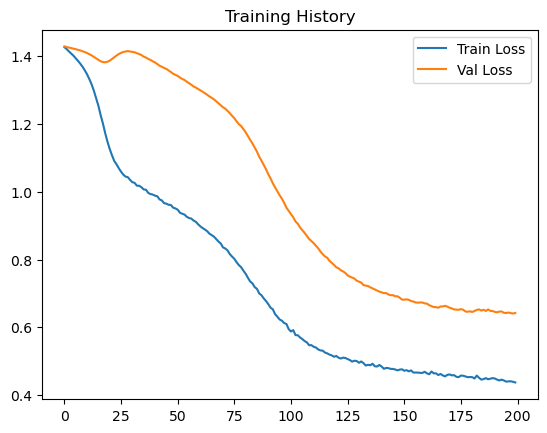

In [70]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout):
        super(SimpleLSTM, self).__init__()
        
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # x shape: (batch, seq_len, input_dim)
        lstm_out, _ = self.lstm(x)
        
        # Take only the last time step
        last_step = lstm_out[:, -1, :]
        
        out = self.fc(last_step)
        return out

model = SimpleLSTM(
    input_dim=len(INPUT_COLS),
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    output_dim=len(encoder.classes_),
    dropout=DROPOUT
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_losses = []
val_losses = []

print("Starting training...")

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
            
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_acc = 100 * correct / total
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}] Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")

# Plot
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Training History")
plt.legend()
plt.show()


--- Test Set Classification Report (Raw Data) ---
              precision    recall  f1-score   support

         0.0       0.77      0.67      0.72       391
         2.0       0.94      0.90      0.92       364
         3.0       0.86      0.97      0.91      1431
         4.0       0.59      0.32      0.41       231

    accuracy                           0.85      2417
   macro avg       0.79      0.71      0.74      2417
weighted avg       0.83      0.85      0.83      2417



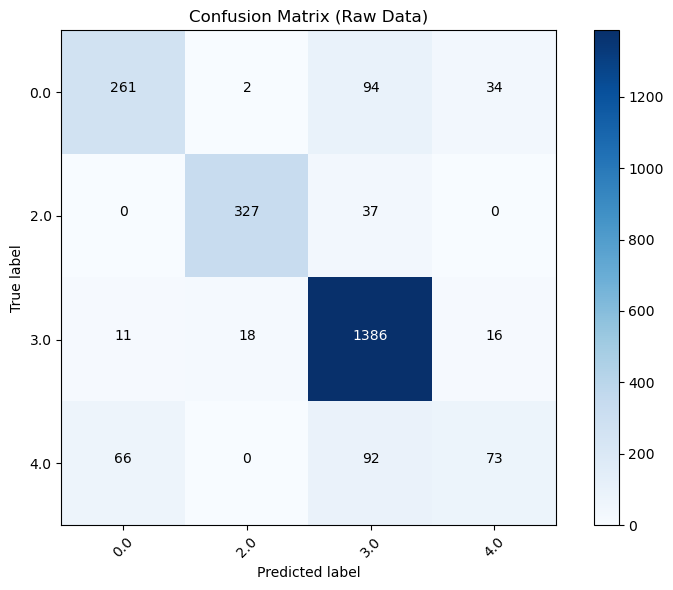

In [71]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.numpy())

# Evaluation Metrics
print("\n--- Test Set Classification Report (Raw Data) ---")
print(classification_report(all_labels, all_preds, target_names=encoder.classes_, zero_division=0))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Raw Data)')
plt.colorbar()

tick_marks = np.arange(len(encoder.classes_))
plt.xticks(tick_marks, encoder.classes_, rotation=45)
plt.yticks(tick_marks, encoder.classes_)

thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

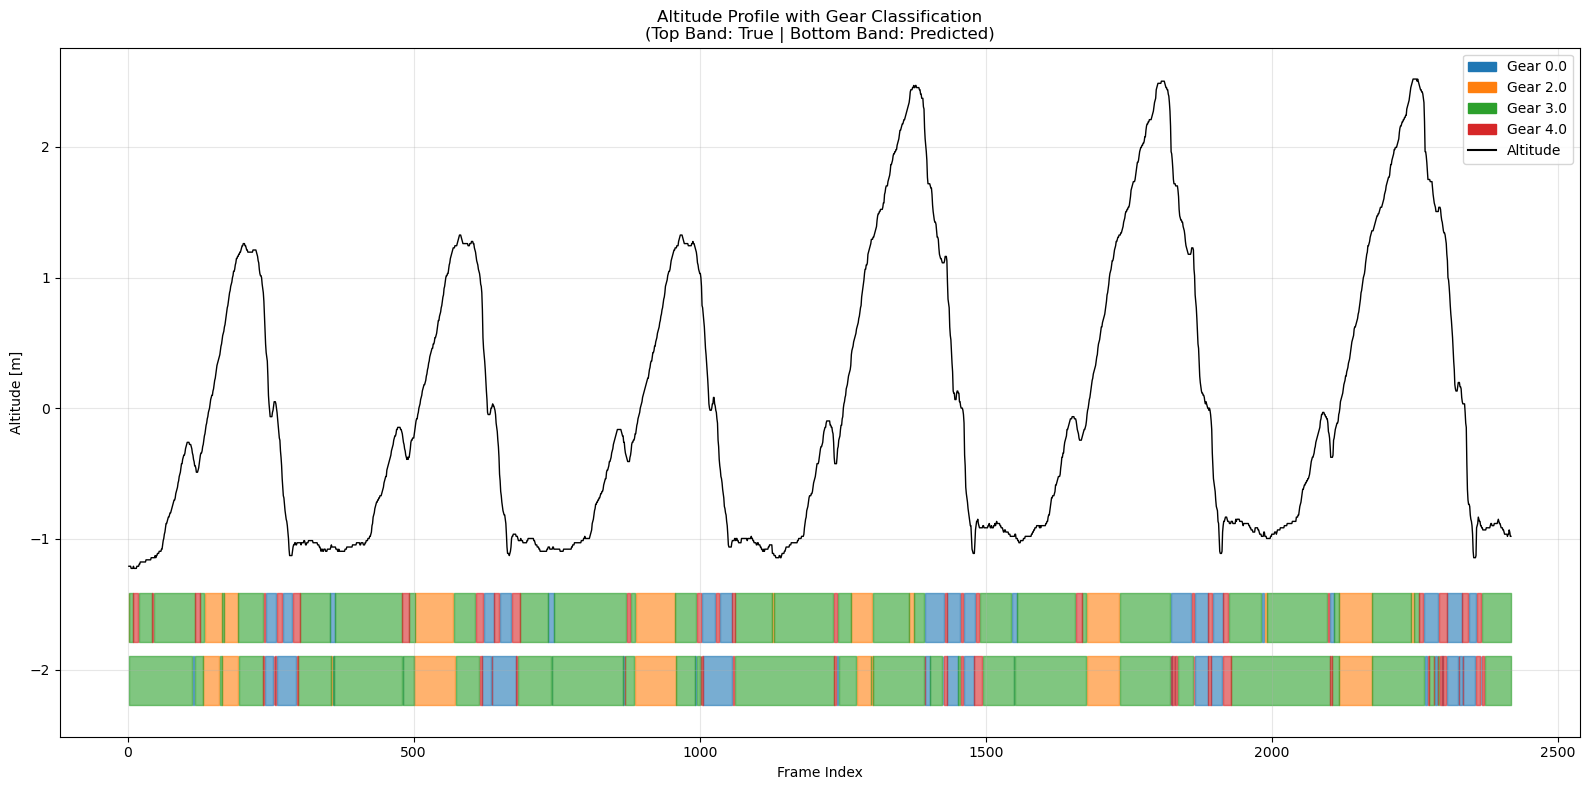

In [72]:
# ==========================================
# ALTITUDE vs TIME + TRUE/PRED GEAR BANDS
# ==========================================

import matplotlib.patches as mpatches

# 1. Align Data
# Since the model consumes a sequence (SEQ_LEN) to predict the label at the last step,
# we must align the Time/Altitude data by slicing off the first (SEQ_LEN - 1) frames.
# Note: We assume STEP=1. If STEP > 1, slicing would be test_df.iloc[SEQ_LEN-1::STEP]

cutoff = SEQ_LEN - 1

# Try to find a Time column, otherwise use index
time_col = 'Time' if 'Time' in test_df.columns else None
if time_col:
    t = test_df[time_col].values[cutoff:]
else:
    print("Warning: 'Time' column not found. Using DataFrame index.")
    t = test_df.index.values[cutoff:]

alt = test_df['ns1:AltitudeMeters'].values[cutoff:]

# Ensure lengths match exactly (handle potential off-by-one errors in edge cases)
min_len = min(len(t), len(all_preds), len(all_labels))
t = t[:min_len]
alt = alt[:min_len]
pred_int = np.array(all_preds)[:min_len]
true_int = np.array(all_labels)[:min_len]

# 2. Decode Labels (Integers -> Original Strings)
# We map integers back to original labels (e.g., 0 -> 'Gear 2') for the legend
pred_str = encoder.inverse_transform(pred_int)
true_str = encoder.inverse_transform(true_int)
unique_classes_str = encoder.classes_

# 3. Setup Colors
# Create a consistent color map for the classes
cmap = plt.get_cmap("tab10")
class_to_color = {cls_name: cmap(i) for i, cls_name in enumerate(unique_classes_str)}

# 4. Plotting
plt.figure(figsize=(16, 8))

# A. Plot Altitude
plt.plot(t, alt, color='black', linewidth=1, label="Altitude", zorder=10)

# Calculate dynamic y-positions for the bands based on altitude range
y_min, y_max = alt.min(), alt.max()
y_range = y_max - y_min

# Band positions (placed slightly below the minimum altitude)
true_band_top = y_min - (0.05 * y_range)
true_band_bot = y_min - (0.15 * y_range)
pred_band_top = y_min - (0.18 * y_range)
pred_band_bot = y_min - (0.28 * y_range)

# B. Plot TRUE Gear Band
# We iterate through unique classes to fill sections
for cls_name in unique_classes_str:
    mask = (true_str == cls_name)
    if np.any(mask):
        plt.fill_between(
            t, true_band_bot, true_band_top,
            where=mask,
            color=class_to_color[cls_name],
            alpha=0.6,
            step='mid' # Important for discrete steps
        )

# C. Plot PREDICTED Gear Band
for cls_name in unique_classes_str:
    mask = (pred_str == cls_name)
    if np.any(mask):
        plt.fill_between(
            t, pred_band_bot, pred_band_top,
            where=mask,
            color=class_to_color[cls_name],
            alpha=0.6,
            step='mid'
        )

# D. Formatting & Legend
plt.xlabel("Time" if time_col else "Frame Index")
plt.ylabel("Altitude [m]")
plt.title("Altitude Profile with Gear Classification\n(Top Band: True | Bottom Band: Predicted)")

# Create custom legend handles
handles = [mpatches.Patch(color=class_to_color[c], label=f"Gear {c}") for c in unique_classes_str]
handles.append(plt.Line2D([], [], color='black', label='Altitude'))

plt.legend(handles=handles, loc="upper right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()